In [1]:
import torch
import numpy as np
import pandas as pd
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

sys.path.insert(0, './src')

from kernels import HMC_our, HMC_vanilla, Reverse_kernel
from models import Gen_network, Inf_network
from target import NN_bernoulli
from utils import plot_digit_samples, get_samples
from args import get_args

from data import Dataset

In [2]:

general_name = 'data_mnist_K_2_N_1_fixtransition_False_amortize_False_learnreverse_True_vanillaepoches_0_hoffmanlike_True'

NUM_EVALS = 3

In [3]:
args = get_args()

args.device = "cuda:1"
args.std_normal = torch.distributions.Normal(loc=torch.tensor(0., dtype=args.torchType, device=args.device),
                                            scale=torch.tensor(1., dtype=args.torchType, device=args.device))
dataset = Dataset(args, args.device)

In [4]:
for key, value in zip(general_name.split('_')[::2], general_name.split('_')[1::2]):
    if value.isdigit():
        args[key] = int(value)
    elif value in ['True', 'False']:
        args[key] = True if value=='True' else False
    else:
        args[key] = value

In [5]:
#### First, we load train models and fix their params
decoder = torch.load('./models/mnist/best_decoder_{}.pt'.format(general_name), map_location=args.device)
decoder.eval()
for p in decoder.parameters():
    p.requires_grad_(False)
target = NN_bernoulli(args, decoder, args.device)
    
encoder = torch.load('./models/mnist/best_encoder_{}.pt'.format(general_name), map_location=args.device)
encoder.eval()
for p in encoder.parameters():
    p.requires_grad_(False)
    
transitions = torch.load('./models/mnist/best_transitions_{}.pt'.format(general_name), map_location=args.device)
transitions.eval()
if args.amortize:
    transitions.device = args.device
else:
    for k in range(args.K):
        transitions[k].device = args.device
for p in transitions.parameters():
    p.requires_grad_(False)
    
if args.learnable_reverse:
    reverse_kernel = torch.load('./models/mnist/best_reverse_{}.pt'.format(general_name), map_location=args.device)
    reverse_kernel.eval()
    reverse_kernel.device = args.device
    for p in reverse_kernel.parameters():
        p.requires_grad_(False)

Saved samples to ./pics/mnist_epoch_-1_K_2_N_1_amortize_False.png


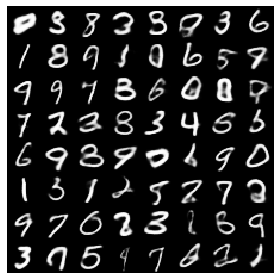

In [6]:
plot_digit_samples(samples=get_samples(target.decoder,
                                       torch.distributions.Normal(loc=torch.tensor(0., device=args.device),
                                                                 scale=torch.tensor(1., device=args.device)).sample((64, args.z_dim))),
                   args=args, epoch=-1)

### NLL estimation using importance sampling with inference part from training

In [7]:
def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), mu=mu.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new).sum(1)
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo

In [8]:
# def compute_marginal_q(z_final, K, x, mu=None, sigma=None):
#     aux_matrix = torch.empty((z_final.shape[0], 3**K), device=device, dtype=torchType)
#     directions_all = np.array(list(itertools.product(np.arange(3) - 1, repeat=K)))
#     cond_distr = torch.distributions.Normal(loc=mu, scale=sigma)
#     for d_num, directions in enumerate(directions_all):
#         sum_log_alpha = torch.zeros(z_final.shape[0], dtype=torchType, device=device) # for grad log alpha accumulation
#         sum_log_jacobian = torch.zeros(z_final.shape[0], dtype=torchType, device=device) # for log_jacobian accumulation
#         z = z_final
#         for k in range(K)[::-1]:
#             if directions[k]==1.:
#                 current_log_alphas = transitions[k].get_log_alpha_1(z_old=z, x=x)
#             elif directions[k]==-1:
#                 current_log_alphas = transitions[k].get_log_alpha_m1(z_old=z, x=x)
#             else:
#                 current_log_alphas = transitions[k].get_log_alpha_0(z_old=z, x=x)
#             z_upd, log_jac = transitions[k].make_transition(z_old=z, x=x, directions=directions[k] * torch.ones(z.shape[0], dtype=torchType, device=device),
#                                                             k=cond_vectors[k]) # sample new positions and log_jacobians of transformations
#             sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
#             sum_log_alpha = sum_log_alpha + current_log_alphas
#             z = z_upd
#         log_q_joint = cond_distr.log_prob(z).sum(1) + sum_log_jacobian + sum_log_alpha
#         aux_matrix[:, d_num] = log_q_joint
#     loq_q_marginal = torch.logsumexp(aux_matrix, dim=1)
#     return loq_q_marginal

In [9]:
means = []
stds = []
for _ in range(NUM_EVALS):
    nll = []
    for test_batch in tqdm(dataset.next_test_batch(), total=dataset.test.shape[0] // dataset.test_batch_size):
        mu, sigma = encoder(test_batch)

        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u

        p_old = args.std_normal.sample(z.shape)
        cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]
        p = p_old
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None

        for k in range(args.K):
    #         pdb.set_trace()
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=test_batch,
                                                    p_old=p, k=cond_vectors[k], target_distr=target)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=test_batch,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
        nll_current, _ = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=test_batch, sum_log_alpha=sum_log_alpha,
                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)

        nll.append(nll_current.cpu().detach().numpy())
    means.append(np.mean(nll))

100%|██████████| 1000/1000 [1:15:26<00:00,  4.53s/it]


In [10]:
print(means)

[-91.25834, -91.260216, -91.23415]


In [11]:
print('Mean', np.mean(means))
print('Std', np.std(means))

Mean -91.25091
Std 0.011868138


In [8]:
d = {}
for key, value in zip(general_name.split('_')[::2], general_name.split('_')[1::2]):
    if value.isdigit():
        d[key] = [int(value)]
    elif value in ['True', 'False']:
        d[key] = [True if value=='True' else False]
    else:
        d[key] = [value]
d['Mean'] = [np.mean(means)]
d['std'] = [np.std(means)]
d['eval_method'] = ['IS_with_same_inference_part']

In [9]:
d

{'data': ['mnist'],
 'K': [5],
 'N': [1],
 'fixtransition': [False],
 'amortize': [False],
 'learnreverse': [True],
 'vanillaepoches': [0],
 'hoffmanlike': [True],
 'separateparams': [True],
 'usebatchnorm': [True],
 'decoder': ['deconv'],
 'eval_method': ['IS_with_same_inference_part']}

In [15]:
df_cur = pd.DataFrame(data=d, columns=d.keys())
file_name = './nll_results.csv'
if os.path.exists(file_name):
    df = pd.read_csv(file_name)
    df_cur = pd.concat([df, df_cur])
df_cur.to_csv(file_name, index=False)

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


### NLL estimation using IS and separately trained encoder

In [7]:
from pyro.nn import AutoRegressiveNN, DenseNN
from pyro.distributions.transforms import NeuralAutoregressive
import torch.nn as nn

In [8]:
encoder_aux = Inf_network(args).to(args.device)
best_encoder_aux = Inf_network(args).to(args.device)

flows = []
for i in range(5):
    one_arn = AutoRegressiveNN(args.z_dim, [2 * args.z_dim], param_dims=[2 * args.z_dim] * 3).to(args.device)
    one_flows = NeuralAutoregressive(one_arn, hidden_units=256)
    flows.append(one_flows)
variational_flow = nn.ModuleList(flows)

best_flows = []
for i in range(5):
    one_arn = AutoRegressiveNN(args.z_dim, [2 * args.z_dim], param_dims=[2 * args.z_dim] * 3).to(args.device)
    one_flows = NeuralAutoregressive(one_arn, hidden_units=256)
    best_flows.append(one_flows)
best_variational_flow = nn.ModuleList(best_flows)

params = list(encoder_aux.parameters()) + list(variational_flow.parameters())

optimizer_aux = torch.optim.Adam(params=params)

  0%|          | 0/1000 [00:00<?, ?it/s]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


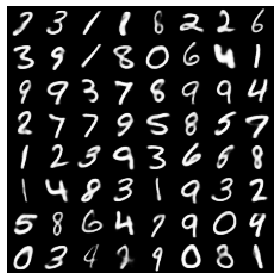

  0%|          | 1/1000 [00:16<4:29:41, 16.20s/it]

Current validation ELBO (epoch 0): -113.61139


  1%|          | 10/1000 [02:41<4:26:10, 16.13s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


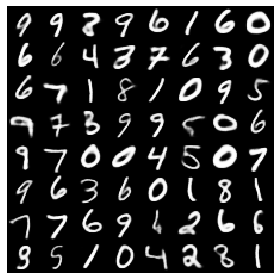

  1%|          | 11/1000 [02:57<4:26:10, 16.15s/it]

Current validation ELBO (epoch 10): -95.584366


  1%|▏         | 13/1000 [03:29<4:25:38, 16.15s/it]

In [ ]:
##### First, we need to train it #####
best_elbo = -float('inf')
current_tolerance = 0

for ep in tqdm(range(1000)):
    for train_batch in dataset.next_train_batch():
        mu, sigma = encoder_aux(train_batch)
        u = args.std_normal.sample(mu.shape)
        z = mu + u * sigma
        z_prev = z
        sum_log_jac = 0.
        for flow in variational_flow:
            z_new = flow(z_prev)
            sum_log_jac += flow.log_abs_det_jacobian(z_prev, z_new)
            z_prev = z_new
        log_p = target.get_logdensity(x=train_batch, z=z_new)
        log_q = args.std_normal.log_prob(u).sum(1) - torch.sum(torch.log(sigma), 1) - sum_log_jac
        elbo = torch.mean(log_p - log_q)
        (-elbo).backward()
        optimizer_aux.step()
        optimizer_aux.zero_grad()
    if ep % 10 == 0:
        plot_digit_samples(samples=get_samples(target.decoder,
                                       z_new[:64]),
                   args=args, epoch=-2)
    ##### Validation #####
    elbo_list = []
    for val_batch in dataset.next_val_batch():
        mu, sigma = encoder_aux(val_batch)
        u = args.std_normal.sample(mu.shape)
        z = mu + u * sigma
        z_prev = z
        sum_log_jac = 0.
        for flow in variational_flow:
            z_new = flow(z_prev)
            sum_log_jac += flow.log_abs_det_jacobian(z_prev, z_new)
            z_prev = z_new
        log_p = target.get_logdensity(x=val_batch, z=z_new)
        log_q = args.std_normal.log_prob(u).sum(1) - torch.sum(torch.log(sigma), 1) - sum_log_jac
        elbo = torch.mean(log_p - log_q).cpu().detach().numpy()
        elbo_list.append(elbo)
    current_elbo_val = np.mean(elbo_list)
    if (current_elbo_val != current_elbo_val).sum():
        print('NAN appeared!')
        raise ValueError
    if current_elbo_val > best_elbo:
        current_tolerance = 0
        best_elbo = current_elbo_val
        best_encoder_aux.load_state_dict(encoder_aux.state_dict())
        best_variational_flow.load_state_dict(variational_flow.state_dict())
    else:
        current_tolerance += 1
        if current_tolerance >= args.early_stopping_tolerance:
            print("Early stopping on epoch {} (effectively trained for {} epoches)".format(ep,
                                              ep - args.early_stopping_tolerance))
            break
    if ep % 10 == 0:
        print('Current validation ELBO (epoch {}):'.format(ep), current_elbo_val)

In [ ]:
for p in best_encoder_aux.parameters():
    p.requires_grad_(False)
for p in best_variational_flow.parameters():
    p.requires_grad_(False)  

In [ ]:
means = []
stds = []
for _ in range(NUM_EVALS):
    nll = []
    for test_batch in tqdm(dataset.next_test_batch(), total=dataset.test.shape[0] // dataset.test_batch_size):
        mu, sigma = best_encoder_aux(test_batch)
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u

        z_prev = z
        sum_log_jac = 0.
        for flow in best_variational_flow:
            z_new = flow(z_prev)
            sum_log_jac += flow.log_abs_det_jacobian(z_prev, z_new)
            z_prev = z_new
        log_p = target.get_logdensity(x=test_batch, z=z_new)
        log_q = args.std_normal.log_prob(u).sum(1) - torch.sum(torch.log(sigma), 1) - sum_log_jac
        nll_current = torch.mean(log_p - log_q)
        nll.append(nll_current.cpu().detach().numpy())
    means.append(np.mean(nll))

In [ ]:
d = {}
for key, value in zip(general_name.split('_')[::2], general_name.split('_')[1::2]):
    if value.isdigit():
        d[key] = [int(value)]
    elif value in ['True', 'False']:
        d[key] = [True if value=='True' else False]
    else:
        d[key] = [value]
d['Mean'] = [np.mean(means)]
d['std'] = [np.std(means)]
d['eval_method'] = ['IS_with_separately_trained_inference_part']

df_cur = pd.DataFrame(data=d, columns=d.keys())
file_name = './nll_results.csv'
if os.path.exists(file_name):
    df = pd.read_csv(file_name)
    df_cur = pd.concat([df, df_cur])
df_cur.to_csv(file_name, index=False)